From now on, many excercises will require a longer training time. To shorten it, you need to start getting familiar with Google Colab. It is possible to run script using the Google GPU (to do that in a colab notebook go to Runtime -> Change runtime type -> Select GPU).

In [1]:
# Uncomment these lines if on colab
#!pip install dgl-cu100
#!pip install --upgrade tables

In [2]:
import dgl
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import ast

## Exercise 3, part 1

Goals of this assignment:

1. Basic introduction to the DGL library https://www.dgl.ai/
2. Train a classifier that takes a point cloud as input (you must achieve validation accuracy over 85%)
3. Learn to work with dgl graphs, node data and batching
4. Build a deepset architecture with dgl mean_nodes and broadcast_nodes functions

First step, download the dataset. It's a modified version of the MNIST dataset where the images have been converted to point clouds.

<b> The task is to classify each graph and say which number it represents. </b>

In [3]:
!unzip ../../Datasets/Dataset_MNIST.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
%load_ext autoreload
%autoreload 2

### DataSet

It is already built in, but it's good to have a look at how DLG graph is created. The graphs:

* have no edges, they are just a collection of nodes;

* their nodes have a feature which is named "xy", which represents the position of the node in 2D space.

The dataset will return a graph and a target class (from 0 to 9).

In [5]:
training_df = pd.read_hdf('Dataset/training_ds.h5')

In [6]:
training_df.head()

,xy,label,n_points
0,"[[-0.35714285714285715, -0.7142857142857143], ...",5,117
1,"[[-0.14285714285714285, 0.2857142857142857], [...",0,130
2,"[[-0.14285714285714285, 0.0], [-0.642857142857...",4,88
3,"[[0.2857142857142857, 0.5], [-0.35714285714285...",1,70
4,"[[-0.42857142857142855, -0.14285714285714285],...",9,97


In [7]:
labels = torch.LongTensor(training_df.label)
n_points = training_df.n_points.values

In [8]:
labels.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [9]:
(n_points)

array([117, 130, 88, ..., 114, 81, 88], dtype=object)

Import the Dataloader already created now!

In [10]:
from dataloader import PointCloudMNISTdataset, collate_graphs

In [11]:
training_dataset = PointCloudMNISTdataset('Dataset/training_ds.h5')
validation_dataset = PointCloudMNISTdataset('Dataset/valid_ds.h5')

In [12]:
g, y = training_dataset[663]

In [13]:
# Graph 663 has 93 nodes, no edges and each node is associated with a property 'xy'

g, y

(Graph(num_nodes=93, num_edges=0,
       ndata_schemes={'xy': Scheme(shape=(2,), dtype=torch.float32)}
       edata_schemes={}),
 tensor(4))

In [14]:
#To see the 2D array of coordinates
#g.ndata['xy']

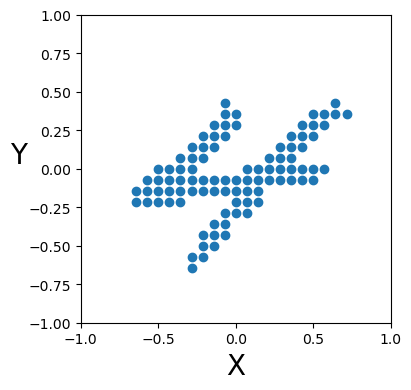

In [15]:
fig,ax = plt.subplots(figsize=(4,4))

xy = g.ndata['xy'].data.numpy()

ax.scatter( xy[:,0],xy[:,1] )

ax.set_ylabel('Y ',fontsize=20,rotation=0)
ax.set_xlabel('X',fontsize=20)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
plt.show()

###  How to batch?

We need to batch our data in a "special" way, we have to tell the pytorch dataloader how to do it. We do this with the collate_graphs function defined in dataloader.py. It uses a function called dgl.batch( ). The batched graph includes all the nodes from all the graphs - and dgl keeps track of which nodes belong to each graph.

In [16]:
from torch.utils.data import Dataset, DataLoader

data_loader = DataLoader(training_dataset, batch_size=300, shuffle=True,
                         collate_fn=collate_graphs)
validation_data_loader = DataLoader(validation_dataset, batch_size=300, shuffle=False,
                         collate_fn=collate_graphs)

In [17]:
for batched_g,y in data_loader:
    break

In [18]:
batched_g,y

(Graph(num_nodes=33202, num_edges=0,
       ndata_schemes={'xy': Scheme(shape=(2,), dtype=torch.float32)}
       edata_schemes={}),
 tensor([4, 0, 1, 1, 2, 8, 0, 9, 2, 1, 1, 5, 4, 7, 1, 1, 9, 4, 5, 6, 9, 6, 6, 0,
         2, 7, 6, 8, 5, 3, 8, 0, 9, 6, 0, 8, 8, 6, 9, 0, 1, 4, 2, 6, 9, 2, 7, 0,
         5, 5, 5, 9, 6, 9, 1, 4, 7, 3, 5, 3, 3, 0, 7, 8, 1, 7, 0, 9, 3, 8, 1, 5,
         1, 4, 7, 6, 4, 6, 2, 6, 4, 7, 2, 1, 4, 3, 8, 9, 8, 8, 6, 9, 9, 5, 0, 7,
         8, 8, 1, 7, 0, 6, 7, 0, 0, 2, 8, 7, 4, 6, 9, 0, 3, 9, 1, 9, 9, 8, 0, 3,
         1, 8, 1, 8, 8, 9, 3, 1, 3, 6, 3, 5, 6, 8, 0, 5, 4, 3, 1, 7, 7, 3, 1, 3,
         0, 7, 2, 8, 8, 4, 1, 1, 8, 9, 8, 8, 4, 6, 4, 6, 3, 2, 1, 2, 7, 3, 4, 1,
         4, 1, 4, 7, 6, 8, 6, 5, 3, 8, 8, 9, 7, 5, 3, 0, 5, 3, 9, 8, 0, 2, 2, 6,
         1, 2, 4, 8, 6, 5, 3, 2, 9, 2, 3, 4, 6, 9, 4, 4, 5, 9, 9, 5, 0, 4, 0, 1,
         3, 2, 5, 6, 4, 9, 8, 9, 0, 7, 0, 5, 4, 7, 1, 0, 0, 0, 3, 2, 6, 1, 2, 6,
         2, 0, 9, 2, 4, 2, 1, 5, 8, 0, 0, 5, 0, 0, 3, 6, 6

In [19]:
batched_g.batch_num_nodes()

tensor([ 81, 175,  36,  71,  61,  93, 136,  47,  56,  69,  48, 140,  65, 116,
         66,  45, 130, 134, 142, 117,  92,  65,  92, 127,  95, 127,  95,  87,
        107, 186, 115, 193, 108, 126, 135, 106, 102, 105,  80, 133,  71, 112,
        124, 184, 119, 179, 105, 132, 143,  72,  72,  71, 107, 160, 136,  60,
        118, 118,  80, 150,  64, 176, 105, 110,  53, 147, 137, 123, 154, 127,
         50,  83,  53, 123,  90, 126, 112, 116, 144, 108,  79, 107, 119,  61,
        160,  58, 114,  89, 133, 134,  86, 129,  89,  85, 190, 108, 130, 141,
        105,  99, 128,  86, 109, 153, 191,  94, 130,  61,  87, 146, 131, 128,
        102,  88,  68,  79, 186, 109, 172,  83,  49, 119,  53, 104,  89,  82,
        102,  73,  67, 100, 132, 118,  75,  98, 117, 161,  82,  93, 127, 120,
        105, 132,  67, 136, 116, 132,  92, 181, 113, 159,  58, 114,  95, 108,
        107, 170,  87, 100, 102,  80,  88, 143,  41, 122,  61, 178,  71, 115,
        112,  66,  94,  78, 124, 116, 171,  97,  83,  87,  87,  

## The model: DeepSets

### Explanation of the structure

A possible model is DeepSets (feel free to implement this or change it). 

<img src="deepset.jpeg" width="800" height="400">

In [20]:
for batched_g,y in data_loader:
    break

In [21]:
(batched_g.ndata['xy'][0])

tensor([ 0.2143, -0.5714])

In [22]:
type(batched_g.ndata['xy']), batched_g.ndata['xy'].shape

(torch.Tensor, torch.Size([32048, 2]))

The input array is N points with features (in this case xy, so 2 dimensions). We need to be able to apply a network to each one of the nodes in the graph. We do that by applying a linear layer to the node features.

In [23]:
# Example of creation of the embedding

linear_layer = nn.Linear(2,10)
# You store the output on the graph itself
batched_g.ndata['hidden rep'] = linear_layer(batched_g.ndata['xy'])

In [24]:
batched_g.ndata['hidden rep'].shape

torch.Size([32048, 10])

Next, we need to be able to take the mean of the hidden represenations in each graph - dgl has a function to do that dgl.mean_nodes( ). This function knows that our graph is a batch of different graphs.

In [25]:
# It extrapolates the graph you are interested in from the total graph created
mean_of_node_rep = dgl.mean_nodes(batched_g,'hidden rep')
mean_of_node_rep.shape

torch.Size([300, 10])

We need to be able to "broadcast" this global mean back to each of the individual nodes, so that they are "aware" of the rest of the graph.

In [26]:
broadcasted_sum = dgl.broadcast_nodes(batched_g,mean_of_node_rep)

In [27]:
broadcasted_sum.shape

torch.Size([32048, 10])

We assign this broadcasted global rep as a feature of the nodes

In [28]:
batched_g.ndata['global rep'] = broadcasted_sum

Now we can use it as input for a new linear layer, and we can update the hidden rep for each node. Now the hidden rep for each node contains information from the entire graph

In [29]:
linear_layer2 = nn.Linear(10*2,10)

input_to_layer = torch.cat([
                            batched_g.ndata['global rep'], 
                            batched_g.ndata['hidden rep']],dim=1)

print(input_to_layer.shape)

batched_g.ndata['hidden rep'] = linear_layer2(input_to_layer)

torch.Size([32048, 20])


In [30]:
batched_g.ndata['hidden rep'].shape

torch.Size([32048, 10])

### What model should you build?

The final model should take a graph as input and return a vector of length 10 (remember this is MNIST and our task is to classify digits. This model worked for me, feel free to do whatever you desire.

<img src="model_example.jpeg" width="800" height="400">

In [31]:
from model import Net

In [43]:
net = Net()
net

Net(
  (input_layer): Linear(in_features=2, out_features=100, bias=True)
  (blocks): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=200, out_features=100, bias=True)
      (1): ReLU()
      (2): ModuleList(
        (0): Sequential(
          (0): ReLU()
          (1): Linear(in_features=100, out_features=100, bias=True)
        )
        (1): Sequential(
          (0): ReLU()
          (1): Linear(in_features=100, out_features=100, bias=True)
        )
        (2): Sequential(
          (0): ReLU()
          (1): Linear(in_features=100, out_features=100, bias=True)
        )
        (3): Sequential(
          (0): ReLU()
          (1): Linear(in_features=100, out_features=100, bias=True)
        )
        (4): Sequential(
          (0): ReLU()
          (1): Linear(in_features=100, out_features=100, bias=True)
        )
      )
      (3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (output_layers): Sequential(
    (0): Li

In [44]:
for batched_g,y in data_loader:
    break

In [45]:
net(batched_g).shape

torch.Size([300, 10])

## Training and testing the model

Remeber, the threshold is 85%!!!

Nothing changes here (the 'CUDA' parts will allow you to use the GPU on colab)

In [35]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.00005) 

In [36]:
def compute_accuracy_and_loss(dataloader,net):
    total = 0
    correct = 0
    
    loss = 0
    
    if torch.cuda.is_available():
        net.cuda()
    net.eval()
    
    n_batches = 0
    with torch.no_grad():
        for batched_g,y in dataloader:
            n_batches+=1
            
            if torch.cuda.is_available():
                batched_g = batched_g.to(torch.device('cuda'))
                y = y.cuda()
            pred = net(batched_g)
            
            loss+= loss_func(pred,y).item()
            
            pred = torch.argmax(pred,dim=1)

            correct+=len(torch.where(pred==y)[0])
            total+=len(y)
    loss = loss/n_batches      
    return correct/total, loss

In [47]:
if torch.cuda.is_available():
    net.cuda()

In [48]:
# Run it on colab
# you have to import the .py files and afterwards you need to download the trained_model.pt that it produces

if torch.cuda.is_available() == True:

    n_epochs = 15

    training_loss_vs_epoch = []
    validation_loss_vs_epoch = []

    training_acc_vs_epoch = []
    validation_acc_vs_epoch = []

    pbar = tqdm( range(n_epochs) )

    for epoch in pbar:

        if len(validation_loss_vs_epoch) > 1:
            pbar.set_description('val acc:'+'{0:.5f}'.format(validation_acc_vs_epoch[-1])+', train acc:'+'{0:.5f}'.format(training_acc_vs_epoch[-1]))

        net.train() # put the net into "training mode"
        for batched_g,y in data_loader:
            if torch.cuda.is_available():
                batched_g = batched_g.to(torch.device('cuda'))
                y = y.cuda()

            optimizer.zero_grad()
            pred = net(batched_g)
            loss = loss_func(pred,y)
            loss.backward()
            optimizer.step()

        net.eval() #put the net into evaluation mode
        train_acc, train_loss = compute_accuracy_and_loss(data_loader,net)
        valid_acc, valid_loss = compute_accuracy_and_loss(validation_data_loader,net)

        training_loss_vs_epoch.append(train_loss)    
        training_acc_vs_epoch.append(train_acc)

        validation_acc_vs_epoch.append(valid_acc)

        validation_loss_vs_epoch.append(valid_loss)
        if len(validation_loss_vs_epoch)==1 or validation_loss_vs_epoch[-2] > validation_loss_vs_epoch[-1]:
            torch.save(net.state_dict(), 'trained_model.pt')

  0%|          | 0/15 [00:00<?, ?it/s]

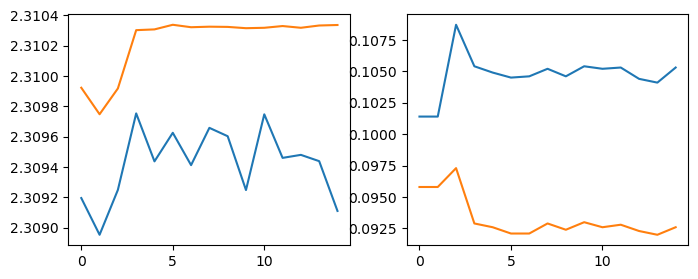

In [49]:
if torch.cuda.is_available() == True:
    
    fig,ax = plt.subplots(1,2,figsize=(8,3))

    ax[0].plot(training_loss_vs_epoch,label='training')
    ax[0].plot(validation_loss_vs_epoch,label='validation')

    ax[1].plot(training_acc_vs_epoch)
    ax[1].plot(validation_acc_vs_epoch)

    plt.show()

In [50]:
net.load_state_dict(torch.load('trained_model.pt',map_location='cpu'))

<All keys matched successfully>

In [51]:
from evaluate import *

In [52]:
evaluate_on_dataset('Dataset/valid_ds.h5')

0.0923